In [1]:
import numpy as np
from scipy.constants import c
from tqdm.notebook import tqdm
import h5py as hp
import matplotlib.pyplot as plt
from aps_figures.aps_one_column import *
from FITX import fit_risetime
from mbtrack2 import Synchrotron, Electron
from mbtrack2.utilities import Optics
from mbtrack2.tracking import LongitudinalMap, SynchrotronRadiation, TransverseMap
from mbtrack2.tracking import Beam, Bunch, WakePotential
from mbtrack2.tracking import RFCavity, SynchrotronRadiation
from mbtrack2.tracking.monitors import BunchMonitor, WakePotentialMonitor
from machine_data.TDR2 import *

In [2]:
from SOLEILII_parameters.SOLEILII_TDR_parameters import *
h = H_RF # Harmonic number of the accelerator.
L = CIRCUMFERENCE # Ring circumference in [m].
E0 = ENERGY   # Nominal (total) energy of the ring in [eV].
particle = Electron() # Particle considered.
ac = ALPHA_0  # Momentum compaction factor.
U0 = U_LOSS   # Energy loss per turn in [eV].
tau = np.array([TAU_X, TAU_Y, TAU_Z]) # Horizontal, vertical and longitudinal damping times in [s].
tune = np.array([Q_X, Q_Y]) # Horizontal and vertical tunes.
emit = np.array([EPSILON_X, EPSILON_Y]) # Horizontal and vertical equilibrium emittance in [m.rad].
sigma_0 = SIGMA_Z/c # Natural bunch length in [s].
sigma_delta = SIGMA_DP # Equilibrium energy spread.
chro = [1.6, 1.6] # Horizontal and vertical (non-normalized) chromaticities.
turns=5000

In [3]:
from machine_data.soleil import v2366
ring2 = v2366(IDs='close', load_lattice=False)
optics = ring2.optics
print(Q_X, Q_Y)
print(ring2.tune)

54.2 18.3
[54.2 18.3]


In [4]:
ring = Synchrotron(h=ring2.h, optics=optics, particle=particle, L=ring2.L, E0=ring2.E0, ac=ring2.ac, 
                   U0=ring2.U0, tau=ring2.tau, emit=ring2.emit, tune=ring2.tune, 
                   sigma_delta=ring2.sigma_delta, sigma_0=ring2.sigma_0, chro=chro)

In [5]:
mybunch = Bunch(ring,  mp_number=1e5, current=1.2e-3, alive=True)
np.random.seed(42)
mybunch.init_gaussian()
bunch_monitor = BunchMonitor(0, save_every=1, buffer_size=10, total_size=turns, file_name='bunch_monitor', mpi_mode=False)

In [6]:
long_map = LongitudinalMap(ring)
print('RF cavity voltage phase {:.2f}'.format(np.arccos(ring.U0/V_RF)))
print('RF cavity voltage phase {:.2f}'.format(np.pi - np.arcsin(ring.U0/V_RF)))
print(np.cos(np.pi - np.arcsin(ring.U0/V_RF)))
print(np.sin(np.arccos(ring.U0/V_RF)))
rf = RFCavity(ring, m=1, Vc=V_RF, theta=np.arccos(ring.U0/V_RF))

theta_main =  1.2753602707269827
theta_harmonic = -1.7210480862530364
V_RF_main = 1.78786174535864e6
V_RF_harmonic = 0.4292124905802067e6
main_rf = RFCavity(ring, m=1, Vc=V_RF_main, theta=theta_main)
harmonic_rf = RFCavity(ring, m=4, Vc=V_RF_harmonic, theta=theta_harmonic)
sr = SynchrotronRadiation(ring, switch=[1, 0, 0])
trans_map = TransverseMap(ring)
wakemodel = load_TDR2_wf(version='TDR2.1_IDopen')
wakemodel.drop(['Zlong', 'Zxdip', 'Zydip', 'Wxdip'])
wakefield = WakePotential(ring, wakemodel, n_bin=65)
wakepotential_monitor = WakePotentialMonitor(bunch_number=0, wake_types='Wydip', n_bin=65, save_every=1, 
                 buffer_size=50, total_size=500, file_name=None, mpi_mode=False)

RF cavity voltage phase 1.32
RF cavity voltage phase 2.89
-0.9678717329057733
0.9678717329057733


In [7]:
wakemodel2 = load_TDR2_wf(version='TDR2.1_IDopen')
wakemodel2.drop(['Zlong', 'Zxdip', 'Zydip'])

In [8]:
# positions = np.linspace(0, ring.L, 10)
# trans_sector = TransverseMapSector(ring, 
#                                    alpha_initial=np.array((ALPHA_X_SMOOTH, ALPHA_Y_SMOOTH)),
#                                    alpha_final=np.array((ALPHA_X_SMOOTH, ALPHA_Y_SMOOTH)),
#                                    beta_initial=np.array((BETA_X_SMOOTH,BETA_Y_SMOOTH)),
#                                    beta_final=np.array((BETA_X_SMOOTH,BETA_Y_SMOOTH)),
#                                    dispersion_initial=np.array((0, 0, 0, 0)),
#                                    dispersion_final=np.array((0, 0, 0, 0)),
#                                    phase_diff=np.array((2*pi*Q_X/10, 2*pi*Q_Y/10)),
#                                    chro_diff=np.array((0, 0)),
#                                    adts=None)
# trans_map_sectors = []
# for i in range(0, 10):
#     trans_map_sectors.append(trans_sector)
# trans_map_sectors = transverse_map_sector_generator(ring, positions)
for i in tqdm(range(turns)):
    trans_map.track(mybunch)
    long_map.track(mybunch)
    # rf.track(mybunch)
    main_rf.track(mybunch)
    harmonic_rf.track(mybunch)
    wakefield.track(mybunch)
    sr.track(mybunch)
    bunch_monitor.track(mybunch)
    # if i > (turns - 500):
    wakepotential_monitor.track(mybunch, wakefield)
    

  0%|          | 0/5000 [00:00<?, ?it/s]

<KeysViewHDF5 ['Wydip', 'dipole_Wydip', 'profile_Wydip', 'tau_Wydip', 'time']>


(0.0, 5000.0)

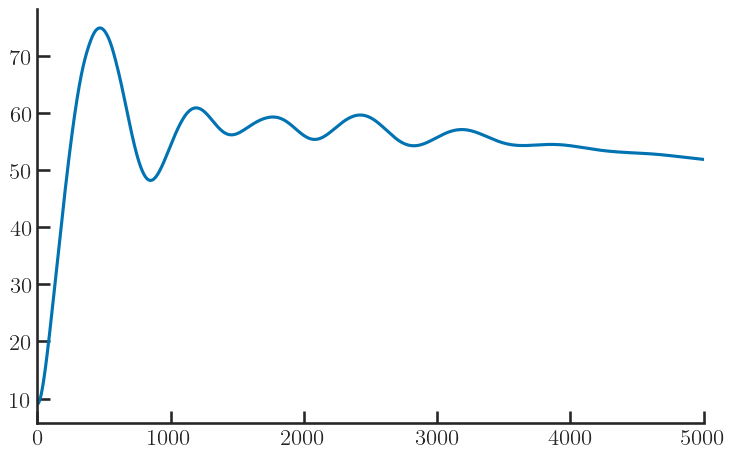

In [43]:
%matplotlib inline
import h5py as hp
filename='bunch_monitor.hdf5'
with hp.File(filename) as f:
    m = f['BunchData_0']['mean'][:]
    std = f['BunchData_0']['std'][:]
    J = f['BunchData_0']['cs_invariant'][:]
    emit = f['BunchData_0']['emit'][:]
    p = f['WakePotentialData_0']['profile_Wydip'][:]
    tau = f['WakePotentialData_0']['tau_Wydip'][:]
    print(f['WakePotentialData_0'].keys())
from matplotlib import pyplot as plt
plt.plot(std[4,:]/1e-12)
plt.xlim(0, 5000)

9.009561378442552


(-45.04780689221276, 45.04780689221276)

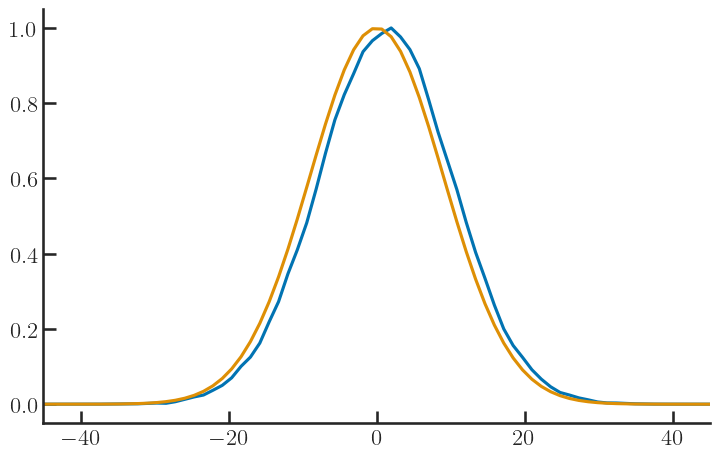

In [47]:
tau.shape
p.shape
plt.plot(tau[:, 0]/1e-12, p[:, 0]/np.max(p[:,0]))
y = np.exp(-.5*(tau[:, 0]/std[4,0])**2)
print(std[4,0]/1e-12)
plt.plot(tau[:, 0]/1e-12, y)
plt.xlim(-5*std[4,0]/1e-12, 5*std[4,0]/1e-12)

/home/gubaidulin/Codes/TrackingCodes/mbtrack2/mbtrack2/utilities/misc.py:290: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data = impedance.data.append(negative_data)


(-1.0, 1.0)

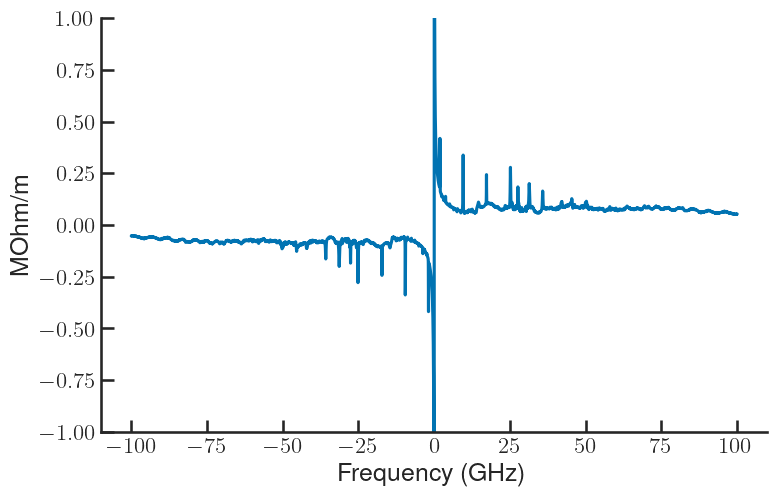

In [11]:
%matplotlib inline
from mbtrack2.utilities.misc import effective_impedance, head_tail_form_factor, spectral_density, double_sided_impedance
from tqdm.notebook import tqdm
Q_s = 1.95e-3
Zydip_obj = load_TDR2_wf(version='TDR2.1_IDopen').Zydip
Zydip_close = load_TDR2_wf(version='TDR2.1_IDclose').Zydip

double_sided_impedance(Zydip_obj)

plt.plot(Zydip_obj.data.index/1e9, Zydip_obj.data['real']/1e6, color='b')
# plt.plot(Zydip_obj.data.index/1e9, Zydip_obj.data['imag']/1e6, color='b')
# plt.plot(Zydip_close.data.index/1e9, Zydip_close.data['real']/1e6, color='r')

plt.xlabel('Frequency (GHz)')
plt.ylabel('MOhm/m')
plt.ylim(-1, 1)